Part 1: GAN

Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

fashion_mnist = FashionMNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

100%|██████████| 26421880/26421880 [00:03<00:00, 7356457.42it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 129677.85it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2577820.49it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7778197.76it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [2]:
img, label = fashion_mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


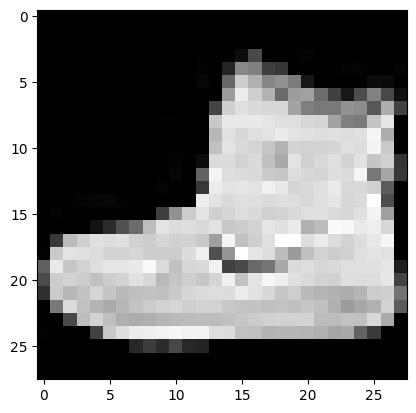

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [5]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([0, 2, 6, 6, 5, 5, 4, 0, 1, 4, 5, 1, 4, 8, 3, 0, 8, 7, 4, 0, 8, 5, 7, 7,
        8, 0, 0, 9, 7, 2, 8, 5, 8, 2, 3, 9, 1, 1, 7, 6, 9, 9, 0, 9, 4, 2, 8, 6,
        8, 4, 1, 0, 2, 8, 1, 7, 8, 0, 0, 2, 9, 7, 7, 4, 0, 4, 9, 5, 7, 5, 7, 2,
        0, 7, 9, 8, 9, 7, 7, 8, 4, 4, 7, 8, 7, 3, 2, 9, 3, 1, 3, 9, 3, 8, 2, 7,
        1, 8, 0, 5])


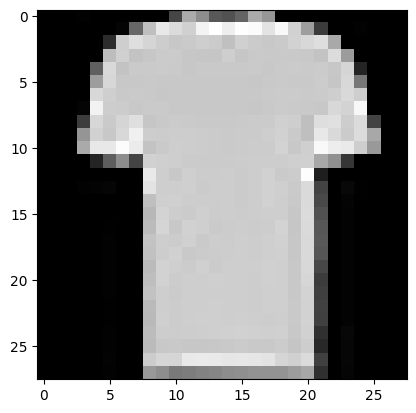

In [6]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda')

Step2. Train the GAN model to produce images in this new domain.



In [9]:
image_size = 784
hidden_size = 256

In [10]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [11]:
D.to(device);

In [12]:
latent_size = 64

In [13]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [14]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

In [15]:
# plt.imshow(gen_imgs[0], cmap='gray');

In [16]:
# plt.imshow(gen_imgs[1], cmap='gray');

In [17]:
G.to(device);

In [18]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [19]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

In [20]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [21]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [22]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

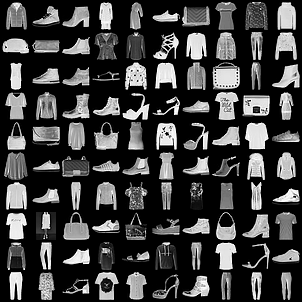

In [23]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


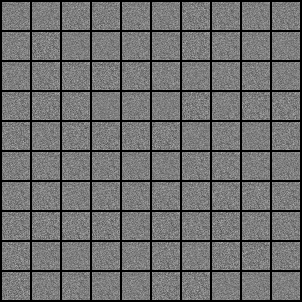

In [24]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [25]:
%%time

num_epochs = 50
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/50], Step [200/600], d_loss: 0.0635, g_loss: 3.9936, D(x): 0.98, D(G(z)): 0.05
Epoch [0/50], Step [400/600], d_loss: 0.4554, g_loss: 5.9723, D(x): 0.84, D(G(z)): 0.05
Epoch [0/50], Step [600/600], d_loss: 0.0321, g_loss: 5.1438, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/50], Step [200/600], d_loss: 0.0398, g_loss: 4.8443, D(x): 0.98, D(G(z)): 0.02
Epoch [1/50], Step [400/600], d_loss: 0.0588, g_loss: 4.2908, D(x): 1.00, D(G(z)): 0.05
Epoch [1/50], Step [600/600], d_loss: 0.0704, g_loss: 4.5970, D(x): 0.98, D(G(z)): 0.02
Saving fake_images-0002.png
Epoch [2/50], Step [200/600], d_loss: 0.0257, g_loss: 8.8331, D(x): 1.00, D(G(z)): 0.02
Epoch [2/50], Step [400/600], d_loss: 0.0252, g_loss: 7.4384, D(x): 0.99, D(G(z)): 0.01
Epoch [2/50], Step [600/600], d_loss: 0.0268, g_loss: 6.9663, D(x): 0.99, D(G(z)): 0.00
Saving fake_images-0003.png
Epoch [3/50], Step [200/600], d_loss: 0.0137, g_loss: 5.3874, D(x): 1.00, D(G(z)): 0.01
Epoch [3/50], Step [400/600], d_loss

In [26]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.

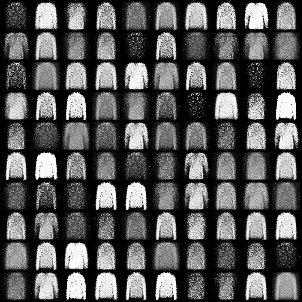

In [27]:
Image('./samples/fake_images-0010.png')

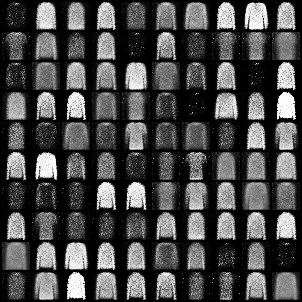

In [28]:
Image('./samples/fake_images-0012.png')

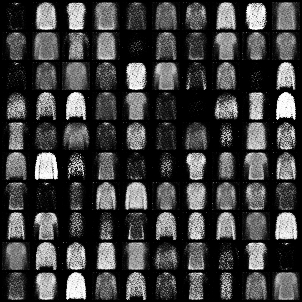

In [29]:
Image('./samples/fake_images-0019.png')

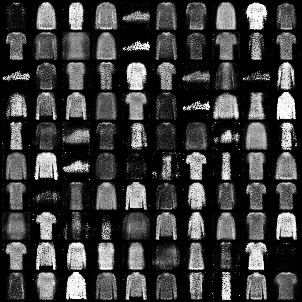

In [30]:
Image('./samples/fake_images-0044.png')

Losses of Discriminator and Generator

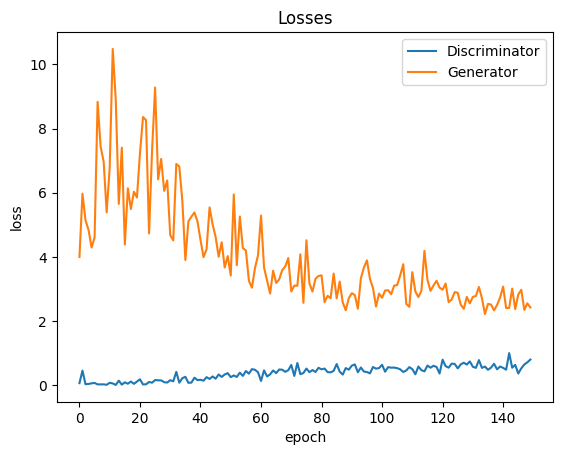

In [31]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

Real Score Vs Fake Score

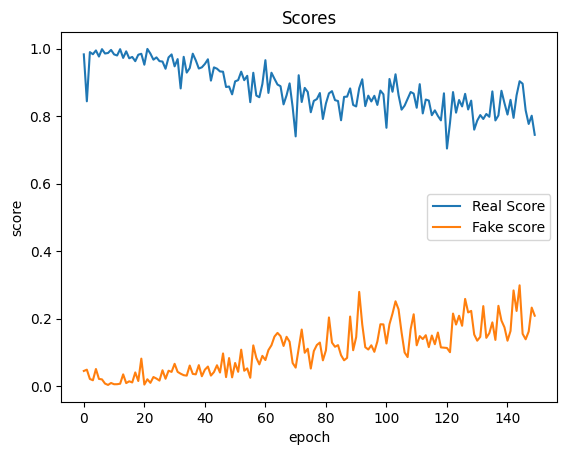

In [32]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [33]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi

In [34]:
# plt.plot(d_losses, '-')
# plt.plot(g_losses, '-')
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.legend(['Discriminator', 'Generator'])
# plt.title('Losses');

In [35]:
# plt.plot(real_scores, '-')
# plt.plot(fake_scores, '-')
# plt.xlabel('epoch')
# plt.ylabel('score')
# plt.legend(['Real Score', 'Fake score'])
# plt.title('Scores');

In [36]:
torch.save(G.state_dict(), 'retrained_generator.pth')
torch.save(D.state_dict(), 'retrained_discriminator.pth')

In [37]:
G.load_state_dict(torch.load('retrained_generator.pth'))
D.load_state_dict(torch.load('retrained_discriminator.pth'))

<All keys matched successfully>

Step4. Save the model weights in the folder to be used later.

In [38]:
import os

# Specify the directory to save model weights
save_dir = 'model_weights'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the generator and discriminator state dictionaries
torch.save(G.state_dict(), os.path.join(save_dir, 'G_weights.pth'))
torch.save(D.state_dict(), os.path.join(save_dir, 'D_weights.pth'))

print("Model weights saved successfully.")


Model weights saved successfully.


Step5. Load the model using the saved weights.



In [39]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_size=64, hidden_size=256, image_size=784):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, image_size=784, hidden_size=256):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [40]:
%%time

num_additional_epochs = 50  # number of epochs to train
start_epoch = 50
end_epoch = start_epoch + num_additional_epochs
total_num_epoch = end_epoch

total_step = len(data_loader)
for epoch in range(start_epoch, end_epoch):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Training of discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspection of  the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, total_num_epoch, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [50/100], Step [200/600], d_loss: 0.6493, g_loss: 2.8235, D(x): 0.83, D(G(z)): 0.22
Epoch [50/100], Step [400/600], d_loss: 0.7442, g_loss: 2.7591, D(x): 0.74, D(G(z)): 0.16
Epoch [50/100], Step [600/600], d_loss: 0.5746, g_loss: 2.3645, D(x): 0.82, D(G(z)): 0.19
Saving fake_images-0051.png
Epoch [51/100], Step [200/600], d_loss: 0.5440, g_loss: 2.4851, D(x): 0.83, D(G(z)): 0.20
Epoch [51/100], Step [400/600], d_loss: 0.9245, g_loss: 1.7902, D(x): 0.80, D(G(z)): 0.31
Epoch [51/100], Step [600/600], d_loss: 0.9151, g_loss: 2.7739, D(x): 0.69, D(G(z)): 0.21
Saving fake_images-0052.png
Epoch [52/100], Step [200/600], d_loss: 0.6676, g_loss: 2.9552, D(x): 0.75, D(G(z)): 0.14
Epoch [52/100], Step [400/600], d_loss: 0.5410, g_loss: 2.8922, D(x): 0.79, D(G(z)): 0.14
Epoch [52/100], Step [600/600], d_loss: 1.0843, g_loss: 2.5236, D(x): 0.66, D(G(z)): 0.21
Saving fake_images-0053.png
Epoch [53/100], Step [200/600], d_loss: 0.7867, g_loss: 2.0917, D(x): 0.77, D(G(z)): 0.20
Epoch [53/100], 

In [41]:
torch.save(G.state_dict(), 'retrained_generator.pth')
torch.save(D.state_dict(), 'retrained_discriminator.pth')

In [42]:
G.load_state_dict(torch.load('retrained_generator.pth'))
D.load_state_dict(torch.load('retrained_discriminator.pth'))

<All keys matched successfully>

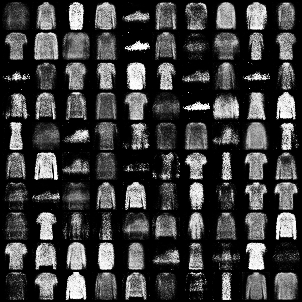

In [43]:
Image('./samples/fake_images-0056.png')

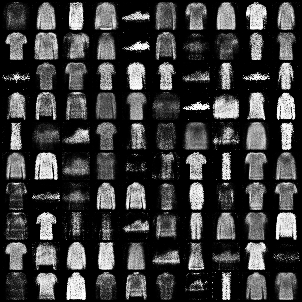

In [44]:
Image('./samples/fake_images-0064.png')

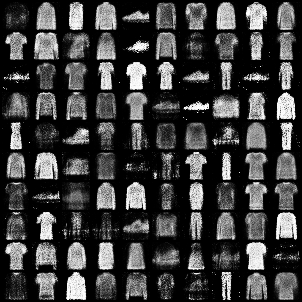

In [45]:
Image('./samples/fake_images-0070.png')

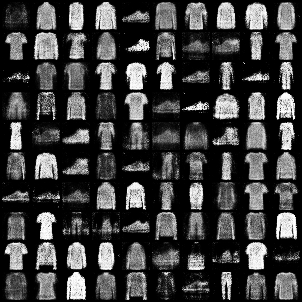

In [46]:
Image('./samples/fake_images-0086.png')

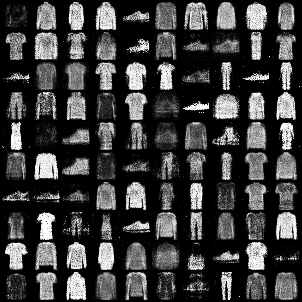

In [47]:
Image('./samples/fake_images-0093.png')

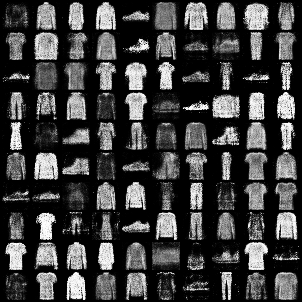

In [48]:
Image('./samples/fake_images-0100.png')

Losses of Discriminator and Generator

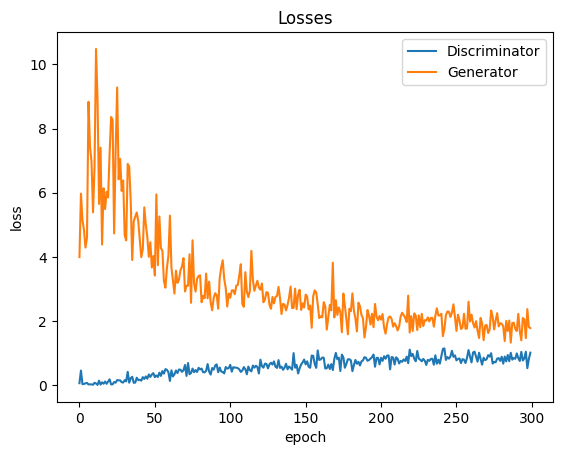

In [49]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

Real Score Vs Fake Score¶

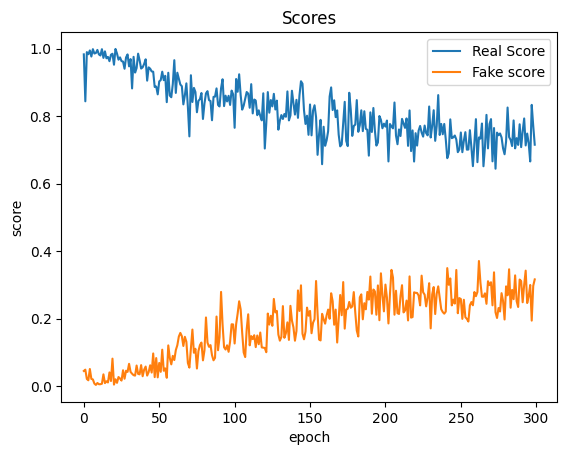

In [50]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');